In [1]:
spark

In [2]:
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model
from pyspark.sql.functions import col, isnull, when, count, expr
from pyspark.sql.types import Row
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
df = spark.read.format('csv').option("header","true").load('Invistico_Airline.csv')

In [4]:
df.columns

['satisfaction',
 'Customer Type',
 'Age',
 'Type of Travel',
 'Class',
 'Flight Distance',
 'Seat comfort',
 'Departure/Arrival time convenient',
 'Food and drink',
 'Gate location',
 'Inflight wifi service',
 'Inflight entertainment',
 'Online support',
 'Ease of Online booking',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Cleanliness',
 'Online boarding',
 'Departure Delay in Minutes',
 'Arrival Delay in Minutes']

In [5]:
df.show(1)

+------------+--------------+---+---------------+-----+---------------+------------+---------------------------------+--------------+-------------+---------------------+----------------------+--------------+----------------------+----------------+----------------+----------------+---------------+-----------+---------------+--------------------------+------------------------+
|satisfaction| Customer Type|Age| Type of Travel|Class|Flight Distance|Seat comfort|Departure/Arrival time convenient|Food and drink|Gate location|Inflight wifi service|Inflight entertainment|Online support|Ease of Online booking|On-board service|Leg room service|Baggage handling|Checkin service|Cleanliness|Online boarding|Departure Delay in Minutes|Arrival Delay in Minutes|
+------------+--------------+---+---------------+-----+---------------+------------+---------------------------------+--------------+-------------+---------------------+----------------------+--------------+----------------------+--------------

In [6]:
# Sparks way of showing data is not really the best formatted, lets see the columns in an organized format
df.printSchema()

root
 |-- satisfaction: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: string (nullable = true)
 |-- Seat comfort: string (nullable = true)
 |-- Departure/Arrival time convenient: string (nullable = true)
 |-- Food and drink: string (nullable = true)
 |-- Gate location: string (nullable = true)
 |-- Inflight wifi service: string (nullable = true)
 |-- Inflight entertainment: string (nullable = true)
 |-- Online support: string (nullable = true)
 |-- Ease of Online booking: string (nullable = true)
 |-- On-board service: string (nullable = true)
 |-- Leg room service: string (nullable = true)
 |-- Baggage handling: string (nullable = true)
 |-- Checkin service: string (nullable = true)
 |-- Cleanliness: string (nullable = true)
 |-- Online boarding: string (nullable = true)
 |-- Departure Delay in Minutes: string (nullable = t

In [7]:
# Show select columns in an organized format using pandas
df.select("satisfaction", "Food and drink", 
          "Gate location", "Inflight wifi service", 
          "Inflight entertainment", "On-board service", 
          "Leg room service", "Baggage handling", "Cleanliness", 
          "Departure Delay in Minutes", "Arrival Delay in Minutes").toPandas().head()

,satisfaction,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,On-board service,Leg room service,Baggage handling,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,0,2,2,4,3,0,3,3,0,0.0
1,satisfied,0,3,0,2,4,4,4,3,310,305.0
2,satisfied,0,3,2,0,3,3,4,4,0,0.0
3,satisfied,0,3,3,4,1,0,1,1,0,0.0
4,satisfied,0,3,4,3,2,0,2,2,0,0.0


In [8]:
# Get some useful metrics
df.toPandas().describe()

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
count,129880,129880,129880,129880,129880,129880,129880,129880,129880,129880,...,129880,129880,129880,129880,129880,129880,129880,129880,129880,129487
unique,2,2,75,2,3,5398,6,6,6,6,...,6,6,6,6,5,6,6,6,466,472
top,satisfied,Loyal Customer,39,Business travel,Business,1963,3,4,3,3,...,4,4,4,4,4,4,4,4,0,0.0
freq,71087,106100,3692,89693,62160,92,29183,29593,28150,33546,...,41510,39920,40675,39698,48240,36481,48795,35181,73356,72753


In [9]:
# Get count of df entries(num rows)
df.count()

129880

In [10]:
# convert column types from strings to ints
columns_to_convert = ['Seat comfort', 'Departure/Arrival time convenient', 'Age',
                      'Food and drink', 'Gate location', 'Inflight wifi service', 
                      'Inflight entertainment', 'Online support', 'Ease of Online booking',
                      'On-board service', 'Leg room service', 'Baggage handling', 
                      'Checkin service', 'Cleanliness', 'Online boarding']

for column in columns_to_convert:
    df = df.withColumn(column, col(column).cast('int'))

# convert column types from strings to doubles (prices and distance)
columns_to_convert = ['Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Flight Distance']

for column in columns_to_convert:
    df = df.withColumn(column, col(column).cast('float'))

In [11]:
# Verify changes
df.printSchema()

root
 |-- satisfaction: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: float (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- Online support: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)
 |-- Departure Delay in Minutes: float 

In [12]:
# setup encoder for columns
stringIndexer_label = StringIndexer(inputCol = 'satisfaction', outputCol = 'label').fit(df)
stringIndexer_class = StringIndexer(inputCol = 'Class', outputCol = 'class_encoded')
stringIndexer_travelType = StringIndexer(inputCol = 'Type of Travel', outputCol = 'travel_encoded')
stringIndexer_customerType = StringIndexer(inputCol = 'Customer Type', outputCol = 'customer_encoded')

In [13]:
# Get the null rows count and print out 
pandas_df = df.toPandas()
null_rows_count = pandas_df.isnull().any(axis=1).sum()
print(null_rows_count)
print(pandas_df[pandas_df.isnull().any(axis=1)].head())

393
     satisfaction   Customer Type  Age   Type of Travel Class  \
145     satisfied  Loyal Customer   21  Personal Travel   Eco   
246     satisfied  Loyal Customer   28  Personal Travel   Eco   
710     satisfied  Loyal Customer   28  Personal Travel   Eco   
736     satisfied  Loyal Customer    9  Personal Travel   Eco   
818  dissatisfied  Loyal Customer    9  Personal Travel   Eco   

     Flight Distance  Seat comfort  Departure/Arrival time convenient  \
145           4804.0             0                                  2   
246           1364.0             0                                  3   
710           1792.0             0                                  5   
736           1862.0             0                                  5   
818           1668.0             1                                  0   

     Food and drink  Gate location  ...  Online support  \
145               0              4  ...               5   
246               0              4  ...         

In [14]:
# The NAN come from Arrival Delay in Minutes, if NAN we are assuming there is no delay so set rows with NAN to 0 for delay
df = df.withColumn(
    'Arrival Delay in Minutes',
    when(df['Arrival Delay in Minutes'].isNull(),0.0).otherwise(df['Arrival Delay in Minutes']))

In [15]:
# To reduce num of columns going into model, making a single column for total delay
df = df.withColumn("total_delay_in_minutes", col("Departure Delay in Minutes") + col("Arrival Delay in Minutes"))
df.toPandas().head()

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,total_delay_in_minutes
0,satisfied,Loyal Customer,65,Personal Travel,Eco,265.0,0,0,0,2,...,3,3,0,3,5,3,2,0.0,0.0,0.0
1,satisfied,Loyal Customer,47,Personal Travel,Business,2464.0,0,0,0,3,...,3,4,4,4,2,3,2,310.0,305.0,615.0
2,satisfied,Loyal Customer,15,Personal Travel,Eco,2138.0,0,0,0,3,...,2,3,3,4,4,4,2,0.0,0.0,0.0
3,satisfied,Loyal Customer,60,Personal Travel,Eco,623.0,0,0,0,3,...,1,1,0,1,4,1,3,0.0,0.0,0.0
4,satisfied,Loyal Customer,70,Personal Travel,Eco,354.0,0,0,0,3,...,2,2,0,2,4,2,5,0.0,0.0,0.0


In [16]:
# Select model columns for model

feature_cols = ['Seat comfort', 'Departure/Arrival time convenient', 'Age',
                      'Food and drink', 'Gate location', 'Inflight wifi service', 
                      'Inflight entertainment', 'Online support', 'Ease of Online booking',
                      'On-board service', 'Leg room service', 'Baggage handling', 
                      'Checkin service', 'Cleanliness', 'Online boarding', 'Flight Distance', 
                      'class_encoded', 'travel_encoded', 'customer_encoded', 'total_delay_in_minutes']

In [17]:
# Vectorize features to a single column and initiate pipeline to encode columns

vectorAssembler_features = VectorAssembler(inputCols = feature_cols, outputCol = "features")
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",labels=stringIndexer_label.labels)

transformed_df_pipeline = Pipeline(stages = [stringIndexer_label, stringIndexer_class, stringIndexer_customerType, 
                                             stringIndexer_travelType, vectorAssembler_features])

transformed_df = transformed_df_pipeline.fit(df).transform(df)

In [18]:
# Select mL algorithms
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
lr = LogisticRegression()
gbt = GBTClassifier(labelCol="label", featuresCol="features")

In [19]:
# 85/15 split of train-test data

split_data = df.randomSplit([0.85, 0.15], 24)
train_data = split_data[0]
test_data = split_data[1]
print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))

Number of training records: 110346
Number of testing records : 19534


In [20]:
pipeline1 = Pipeline(stages = [stringIndexer_label, stringIndexer_class, stringIndexer_customerType,
                               stringIndexer_travelType, vectorAssembler_features, rf, labelConverter])
m1Name = "Random Forest" 

pipeline2 = Pipeline(stages = [stringIndexer_label, stringIndexer_class, stringIndexer_customerType,
                               stringIndexer_travelType, vectorAssembler_features, lr, labelConverter])
m2Name = "Logistic Regression" 

pipeline3 = Pipeline(stages = [stringIndexer_label, stringIndexer_class, stringIndexer_customerType,
                               stringIndexer_travelType, vectorAssembler_features, gbt, labelConverter])
m3Name = "Gradient-boosted tree"


In [21]:
model1 = pipeline1.fit(train_data)
model2 = pipeline2.fit(train_data)
model3 = pipeline3.fit(train_data)

23/12/04 17:41:01 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [22]:
# Get truth table values function given a threshold 

def getCMEntries(threshold):
    newThresholdDF = spark.sql("select label, p1, prediction as oldPrediction,"
    " case when p1 > " + str(threshold) + " then 1.0 else 0.0 end as newPrediction"
    " from inputToThreshold")
    
    newThresholdDF.registerTempTable("newThreshold")
    # number of true positives
    tpA = spark.sql("SELECT * FROM newThreshold WHERE label = 1 AND newprediction = 1")
    # number of false positives
    fpA = spark.sql("SELECT * FROM newThreshold WHERE label = 0 AND newprediction = 1")
    # number of false negatives
    fnA = spark.sql("SELECT * FROM newThreshold WHERE label = 1 AND newprediction = 0")
    # number of true negatives
    tnA = spark.sql("SELECT * FROM newThreshold WHERE label = 0 AND newprediction = 0")
    return (tpA.count(), fpA.count(), fnA.count(), tnA.count())


In [23]:
numThresholds = 20

start = 0.50
end = 0.60
step = 0.005

thresholds = np.arange(start, end + step, step)

In [24]:
def getModelThresholdStats(model_df, data):
    # init confusion matrix
    tp = np.array([i for i in range(0, numThresholds + 1 )])
    fp = np.array([i for i in range(0, numThresholds + 1 )])
    fn = np.array([i for i in range(0, numThresholds + 1 )])
    tn = np.array([i for i in range(0, numThresholds + 1 )])
    
    #generate dataframe to be used in thresholding for reciever operating cahracteristics (TP & FP):
    predictionsForROC = model_df.transform(data)
    
    # Transform ROC df to sql table to query
    predictionsForROC.registerTempTable("predictions")

    # Create table for confusion matrix 
    columnsForCM = spark.sql("select probability, prediction, label from predictions")

    extractedProbability = columnsForCM.rdd.map(lambda x: Row(p1 = float(x[0][1]), prediction=x[1], label=x[2])).toDF() 
    
    extractedProbability.registerTempTable("inputToThreshold")   
    
    # get the total number of positives and negatives in the predictions dataset
    p = spark.sql("SELECT * from predictions WHERE label = 1").count()
    n = spark.sql("SELECT * from predictions WHERE label = 0").count()
    # We know the number of true positives, etc. at the threshold edges:
    (tp[0],fp[0],fn[0],tn[0]) = (p, n, 0, 0)
    (tp[-1],fp[-1],fn[-1],tn[-1]) = (0, 0, p, n)

    # Create a tracking of the best threshold and its individual stats to print out formal confusion matrix
    maxAcc, maxThreshold, tpBest, fpBest, fnBest, tnBest = 0, 0, 0, 0, 0, 0
    
    for (i, threshold) in zip(range(0, numThresholds + 1),thresholds):
        print(i, threshold)
        if (i>0 and i<numThresholds):
            (tp[i],fp[i],fn[i],tn[i]) = getCMEntries(threshold)
            print(tp[i],fp[i],fn[i],tn[i])
            # Get accuracy for particular threshold
            acc = (tp[i] + tn[i])/(tp[i] + fp[i] + fn[i] + tn[i])
            print('Accuracy for threshold', threshold, acc)
            if (acc > maxAcc):
                maxAcc = acc
                maxThreshold = threshold
                tpBest, fpBest, fnBest, tnBest = tp[i], fp[i], fn[i], tn[i]
                
    tp = tp*1.0; fp=fp*1.0; p=p*1.0; n=n*1.0
    tpr = tp/(tp + fn)
    fpr = fp/(fp + tn)
    accThreshold = (tp + tn) / (p + n)
    
    print('Max accuracy is ', maxAcc, ' for threshold ', maxThreshold)
   
    return (maxAcc, accThreshold, maxThreshold, tpBest, fpBest, fnBest, tnBest)

In [25]:
print("getting stats for " + m1Name + ": train")
(maxAcc1, acc1, thresh1, tp1, fp1, fn1, tn1) = getModelThresholdStats(model1, train_data)
print("getting stats for " + m1Name + ": test")
(maxAcc1Test, acc1Test, thresh1Test, tp1Test, fp1Test, fn1Test, tn1Test) = getModelThresholdStats(model1, test_data)
print("getting stats for " + m2Name + ": train")
(maxAcc2, acc2, thresh2, tp2, fp2, fn2, tn2) = getModelThresholdStats(model2, train_data)
print("getting stats for " + m1Name + ": test")
(maxAcc2Test, acc2Test, thresh2Test, tp2Test, fp2Test, fn2Test, tn2Test) = getModelThresholdStats(model2, test_data)
print("getting stats for " + m3Name + ": train")
(maxAcc3, acc3, thresh3, tp3, fp3, fn3, tn3) = getModelThresholdStats(model3, train_data)
print("getting stats for " + m3Name + ": test")
(maxAcc3Test, acc3Test, thresh3Test, tp3Test, fp3Test, fn3Test, tn3Test) = getModelThresholdStats(model3, test_data)


getting stats for Random Forest: train


/Users/nicholasmcgourthy/anaconda3/lib/python3.11/site-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)
23/12/04 17:45:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


0 0.5
1 0.505


42558 4769 7449 55570
Accuracy for threshold 0.505 0.8892755514472659
2 0.51


42477 4685 7530 55654
Accuracy for threshold 0.51 0.8893027386584017
3 0.515


42345 4454 7662 55885
Accuracy for threshold 0.515 0.8901999166258858
4 0.52


42235 4350 7772 55989
Accuracy for threshold 0.52 0.8901455422036141
5 0.525


42131 4252 7876 56087
Accuracy for threshold 0.525 0.8900911677813423
6 0.53


42020 4103 7987 56236
Accuracy for threshold 0.53 0.8904355391223968
7 0.535


41846 3859 8161 56480
Accuracy for threshold 0.535 0.891069907382234
8 0.54


41756 3770 8251 56569
Accuracy for threshold 0.54 0.8910608449785221
9 0.545


41650 3650 8357 56689
Accuracy for threshold 0.545 0.8911877186304895
10 0.55


41530 3569 8477 56770
Accuracy for threshold 0.55 0.8908342848857231
11 0.555


41379 3507 8628 56832
Accuracy for threshold 0.555 0.8900277309553586
12 0.56


41268 3446 8739 56893
Accuracy for threshold 0.56 0.8895746107697605
13 0.5650000000000001


41170 3378 8837 56961
Accuracy for threshold 0.5650000000000001 0.8893027386584017
14 0.5700000000000001


41042 3304 8965 57035
Accuracy for threshold 0.5700000000000001 0.8888133688579559
15 0.5750000000000001


40954 3235 9053 57104
Accuracy for threshold 0.5750000000000001 0.8886411831874287
16 0.5800000000000001


40811 3167 9196 57172
Accuracy for threshold 0.5800000000000001 0.8879615029090316
17 0.5850000000000001


40615 3098 9392 57241
Accuracy for threshold 0.5850000000000001 0.8868105776376126
18 0.5900000000000001


40452 3032 9555 57307
Accuracy for threshold 0.5900000000000001 0.8859315244775524
19 0.5950000000000001


40294 2939 9713 57400
Accuracy for threshold 0.5950000000000001 0.8853424682362749
20 0.6000000000000001
Max accuracy is  0.8911877186304895  for threshold  0.545
getting stats for Random Forest: test


0 0.5
1 0.505


7492 869 1294 9879
Accuracy for threshold 0.505 0.8892699907852974
2 0.51


7482 856 1304 9892
Accuracy for threshold 0.51 0.889423569161462
3 0.515


7464 820 1322 9928
Accuracy for threshold 0.515 0.8903450394184499
4 0.52
7437 796 1349 9952
Accuracy for threshold 0.52 0.8901914610422852
5 0.525
7420 779 1366 9969
Accuracy for threshold 0.525 0.8901914610422852
6 0.53
7399 756 1387 9992
Accuracy for threshold 0.53 0.890293846626395
7 0.535
7362 715 1424 10033
Accuracy for threshold 0.535 0.8904986177946145
8 0.54
7344 699 1442 10049
Accuracy for threshold 0.54 0.8903962322105048
9 0.545
7322 678 1464 10070
Accuracy for threshold 0.545 0.8903450394184499
10 0.55
7302 666 1484 10082
Accuracy for threshold 0.55 0.8899354970820108
11 0.555
7278 656 1508 10092
Accuracy for threshold 0.555 0.8892187979932425
12 0.56
7252 643 1534 10105
Accuracy for threshold 0.56 0.8885532916965291
13 0.5650000000000001


7238 627 1548 10121
Accuracy for threshold 0.5650000000000001 0.8886556772806389
14 0.5700000000000001
7213 616 1573 10132
Accuracy for threshold 0.5700000000000001 0.8879389781918706
15 0.5750000000000001
7201 603 1585 10145
Accuracy for threshold 0.5750000000000001 0.8879901709839254
16 0.5800000000000001
7179 593 1607 10155
Accuracy for threshold 0.5800000000000001 0.887375857479267
17 0.5850000000000001
7137 583 1649 10165
Accuracy for threshold 0.5850000000000001 0.8857376881335108
18 0.5900000000000001
7113 575 1673 10173
Accuracy for threshold 0.5900000000000001 0.8849186034606328
19 0.5950000000000001
7088 550 1698 10198
Accuracy for threshold 0.5950000000000001 0.8849186034606328
20 0.6000000000000001
Max accuracy is  0.8904986177946145  for threshold  0.535
getting stats for Logistic Regression: train


0 0.5
1 0.505


40350 9309 9657 51030
Accuracy for threshold 0.505 0.828122451198956
2 0.51


40155 9183 9852 51156
Accuracy for threshold 0.51 0.8274971453428307
3 0.515


39980 9039 10027 51300
Accuracy for threshold 0.515 0.82721621082776
4 0.52


39806 8918 10201 51421
Accuracy for threshold 0.52 0.8267359034310261
5 0.525


39604 8799 10403 51540
Accuracy for threshold 0.525 0.8259837239229333
6 0.53


39435 8673 10572 51666
Accuracy for threshold 0.53 0.825594040563319
7 0.535


39247 8552 10760 51787
Accuracy for threshold 0.535 0.8249868595146177
8 0.54


39053 8423 10954 51916
Accuracy for threshold 0.54 0.8243978032733402
9 0.545


38879 8317 11128 52022
Accuracy for threshold 0.545 0.8237815598209269
10 0.55


38694 8205 11313 52134
Accuracy for threshold 0.55 0.8231200043499538
11 0.555


38499 8099 11508 52240
Accuracy for threshold 0.555 0.8223134504195893
12 0.56


38291 7986 11716 52353
Accuracy for threshold 0.56 0.8214525220669531
13 0.5650000000000001


38096 7871 11911 52468
Accuracy for threshold 0.5650000000000001 0.8207275297699962
14 0.5700000000000001


37882 7764 12125 52575
Accuracy for threshold 0.5700000000000001 0.8197578525728164
15 0.5750000000000001


37669 7658 12338 52681
Accuracy for threshold 0.5750000000000001 0.8187881753756366
16 0.5800000000000001


37459 7548 12548 52791
Accuracy for threshold 0.5800000000000001 0.8178819350044406
17 0.5850000000000001


37270 7447 12737 52892
Accuracy for threshold 0.5850000000000001 0.8170844434777881
18 0.5900000000000001


37052 7329 12955 53010
Accuracy for threshold 0.5900000000000001 0.816178203106592
19 0.5950000000000001


36819 7245 13188 53094
Accuracy for threshold 0.5950000000000001 0.8148279049535099
20 0.6000000000000001
Max accuracy is  0.828122451198956  for threshold  0.505
getting stats for Random Forest: test


0 0.5
1 0.505


7117 1672 1669 9076
Accuracy for threshold 0.505 0.8289648817446503
2 0.51
7079 1643 1707 9105
Accuracy for threshold 0.51 0.8285041466161565
3 0.515


7045 1621 1741 9127
Accuracy for threshold 0.515 0.8278898331114979
4 0.52
7019 1596 1767 9152
Accuracy for threshold 0.52 0.827838640319443
5 0.525


6982 1574 1804 9174
Accuracy for threshold 0.525 0.8270707484386198
6 0.53
6958 1552 1828 9196
Accuracy for threshold 0.53 0.82696836285451
7 0.535


6926 1527 1860 9221
Accuracy for threshold 0.535 0.826610013310126
8 0.54


6895 1505 1891 9243
Accuracy for threshold 0.54 0.826149278181632
9 0.545


6855 1481 1931 9267
Accuracy for threshold 0.545 0.8253301935087539
10 0.55


6827 1461 1959 9287
Accuracy for threshold 0.55 0.824920651172315
11 0.555


6796 1442 1990 9306
Accuracy for threshold 0.555 0.8243063376676564
12 0.56


6764 1422 2022 9326
Accuracy for threshold 0.56 0.8236920241629978
13 0.5650000000000001
6740 1391 2046 9357
Accuracy for threshold 0.5650000000000001 0.824050373707382
14 0.5700000000000001


6702 1366 2084 9382
Accuracy for threshold 0.5700000000000001 0.8233848674106686
15 0.5750000000000001
6674 1351 2112 9397
Accuracy for threshold 0.5750000000000001 0.8227193611139552
16 0.5800000000000001


6643 1331 2143 9417
Accuracy for threshold 0.5800000000000001 0.8221562404013515
17 0.5850000000000001


6598 1311 2188 9437
Accuracy for threshold 0.5850000000000001 0.8208764205999796
18 0.5900000000000001


6557 1298 2229 9450
Accuracy for threshold 0.5900000000000001 0.8194430224224429
19 0.5950000000000001


6507 1262 2279 9486
Accuracy for threshold 0.5950000000000001 0.8187263233336746
20 0.6000000000000001
Max accuracy is  0.8289648817446503  for threshold  0.505
getting stats for Gradient-boosted tree: train
0 0.5
1 0.505


45322 4547 4685 55792
Accuracy for threshold 0.505 0.9163358889311801
2 0.51


45249 4492 4758 55847
Accuracy for threshold 0.51 0.9161727656643648
3 0.515


45191 4372 4816 55967
Accuracy for threshold 0.515 0.9167346346945063
4 0.52


45142 4326 4865 56013
Accuracy for threshold 0.52 0.9167074474833705
5 0.525


45075 4236 4932 56103
Accuracy for threshold 0.525 0.9169158827687456
6 0.53


45001 4187 5006 56152
Accuracy for threshold 0.53 0.9166893226759466
7 0.535


44923 4114 5084 56225
Accuracy for threshold 0.535 0.9166440106573868
8 0.54


44832 4055 5175 56284
Accuracy for threshold 0.54 0.916354013738604
9 0.545


44771 3976 5236 56363
Accuracy for threshold 0.545 0.9165171370054194
10 0.55


44666 3899 5341 56440
Accuracy for threshold 0.55 0.9162633897014845
11 0.555


44578 3807 5429 56532
Accuracy for threshold 0.555 0.9162996393163323
12 0.56


44498 3757 5509 56582
Accuracy for threshold 0.56 0.9160277672049735
13 0.5650000000000001


44417 3696 5590 56643
Accuracy for threshold 0.5650000000000001 0.9158465191307342
14 0.5700000000000001


44294 3630 5713 56709
Accuracy for threshold 0.5700000000000001 0.9153299621191525
15 0.5750000000000001


44184 3565 5823 56774
Accuracy for threshold 0.5750000000000001 0.9149221539521143
16 0.5800000000000001


44125 3507 5882 56832
Accuracy for threshold 0.5800000000000001 0.9149130915484023
17 0.5850000000000001


44031 3449 5976 56890
Accuracy for threshold 0.5850000000000001 0.9145868450147717
18 0.5900000000000001


43948 3405 6059 56934
Accuracy for threshold 0.5900000000000001 0.9142334112700052
19 0.5950000000000001


43731 3224 6276 57115
Accuracy for threshold 0.5950000000000001 0.9139071647363747
20 0.6000000000000001
Max accuracy is  0.9169158827687456  for threshold  0.525
getting stats for Gradient-boosted tree: test


0 0.5
1 0.505


7939 831 847 9917
Accuracy for threshold 0.505 0.9140984949319136
2 0.51


7924 816 862 9932
Accuracy for threshold 0.51 0.9140984949319136
3 0.515


7910 800 876 9948
Accuracy for threshold 0.515 0.9142008805160233
4 0.52


7904 788 882 9960
Accuracy for threshold 0.52 0.9145080372683526
5 0.525


7891 776 895 9972
Accuracy for threshold 0.525 0.9144568444762977
6 0.53


7886 767 900 9981
Accuracy for threshold 0.53 0.9146616156445172
7 0.535


7872 755 914 9993
Accuracy for threshold 0.535 0.9145592300604075
8 0.54


7858 738 928 10010
Accuracy for threshold 0.54 0.9147128084365721
9 0.545


7840 721 946 10027
Accuracy for threshold 0.545 0.9146616156445172
10 0.55


7825 712 961 10036
Accuracy for threshold 0.55 0.914354458892188
11 0.555


7818 699 968 10049
Accuracy for threshold 0.555 0.9146616156445172
12 0.56


7806 690 980 10058
Accuracy for threshold 0.56 0.9145080372683526
13 0.5650000000000001


7793 667 993 10081
Accuracy for threshold 0.5650000000000001 0.9150199651889014
14 0.5700000000000001


7774 653 1012 10095
Accuracy for threshold 0.5700000000000001 0.914764001228627
15 0.5750000000000001


7760 643 1026 10105
Accuracy for threshold 0.5750000000000001 0.9145592300604075
16 0.5800000000000001


7746 630 1040 10118
Accuracy for threshold 0.5800000000000001 0.9145080372683526
17 0.5850000000000001


7731 625 1055 10123
Accuracy for threshold 0.5850000000000001 0.9139961093478038
18 0.5900000000000001


7707 613 1079 10135
Accuracy for threshold 0.5900000000000001 0.9133817958431453
19 0.5950000000000001


7662 577 1124 10171
Accuracy for threshold 0.5950000000000001 0.9129210607146514
20 0.6000000000000001
Max accuracy is  0.9150199651889014  for threshold  0.5650000000000001


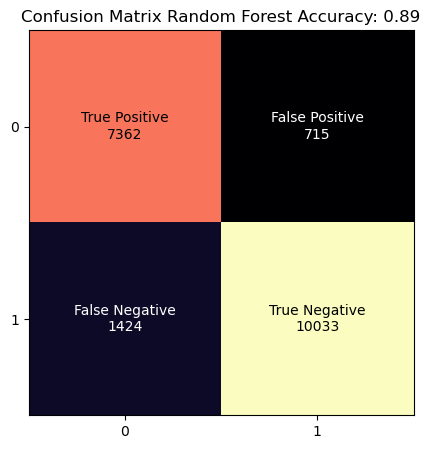

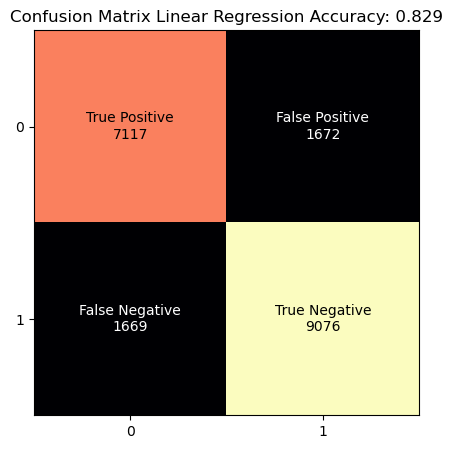

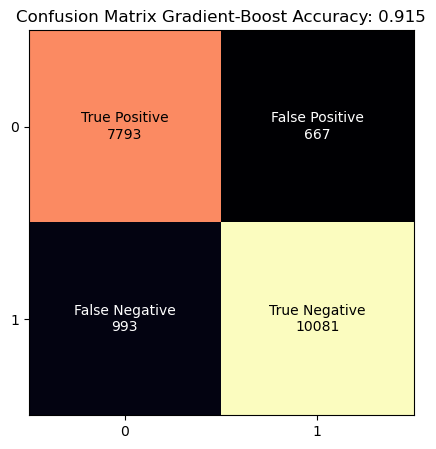

In [42]:
# Random Forests
conf_matrix = [[tp1Test, fp1Test],
                [fn1Test, tn1Test]]
classes = (0,1)
fig, ax = plt.subplots(figsize=(5,5))
cmap = 'magma'
# Using the colormap to get the color intensities of the cells
colors = plt.cm.magma(np.array(conf_matrix)/np.max(conf_matrix))

ax.imshow(conf_matrix, cmap=cmap)
ax.grid(False)
ax.xaxis.set(ticks=(0,1), ticklabels=classes)
ax.yaxis.set(ticks=(0,1), ticklabels=classes)
ax.set_ylim(1.5, -0.5)

# Labels for each cell
cell_labels = [["True Positive", "False Positive"], ["False Negative", "True Negative"]]

for i in range(2):
    for j in range(2):
        # Determine the color intensity of the background
        color_intensity = colors[i, j, :3].mean()
        # Set text color based on background color intensity
        text_color = 'white' if color_intensity < 0.5 else 'black'
        
        # Adding the label with the count value
        text = f"{cell_labels[i][j]}\n{conf_matrix[i][j]}"
        ax.text(j, i, text, ha='center', va='center', color=text_color, fontsize=10)

plt.title('Confusion Matrix Random Forest Accuracy: ' + str(round(maxAcc1Test,3)))
plt.show()

# Linear Regression
conf_matrix = [[tp2Test, fp2Test],
                [fn2Test, tn2Test]]

fig, ax = plt.subplots(figsize=(5,5))
cmap = 'magma'
# Using the colormap to get the color intensities of the cells
colors = plt.cm.magma(np.array(conf_matrix)/np.max(conf_matrix))

ax.imshow(conf_matrix, cmap=cmap)
ax.grid(False)
ax.xaxis.set(ticks=(0,1), ticklabels=classes)
ax.yaxis.set(ticks=(0,1), ticklabels=classes)
ax.set_ylim(1.5, -0.5)

for i in range(2):
    for j in range(2):
        # Determine the color intensity of the background
        color_intensity = colors[i, j, :3].mean()
        # Set text color based on background color intensity
        text_color = 'white' if color_intensity < 0.5 else 'black'
        
        # Adding the label with the count value
        text = f"{cell_labels[i][j]}\n{conf_matrix[i][j]}"
        ax.text(j, i, text, ha='center', va='center', color=text_color, fontsize=10)

plt.title('Confusion Matrix Linear Regression Accuracy: ' + str(round(maxAcc2Test,3)))
plt.show()

# Gradient-Boost
conf_matrix = [[tp3Test, fp3Test],
                [fn3Test, tn3Test]]

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
cmap = 'magma'
# Using the colormap to get the color intensities of the cells
colors = plt.cm.magma(np.array(conf_matrix)/np.max(conf_matrix))

ax.imshow(conf_matrix, cmap=cmap)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=classes)
ax.yaxis.set(ticks=(0, 1), ticklabels=classes)
ax.set_ylim(1.5, -0.5)

for i in range(2):
    for j in range(2):
        # Determine the color intensity of the background
        color_intensity = colors[i, j, :3].mean()
        # Set text color based on background color intensity
        text_color = 'white' if color_intensity < 0.5 else 'black'
        
        # Adding the label with the count value
        text = f"{cell_labels[i][j]}\n{conf_matrix[i][j]}"
        ax.text(j, i, text, ha='center', va='center', color=text_color, fontsize=10)

plt.title('Confusion Matrix Gradient-Boost Accuracy: ' + str(round(maxAcc3Test, 3)))
plt.show()

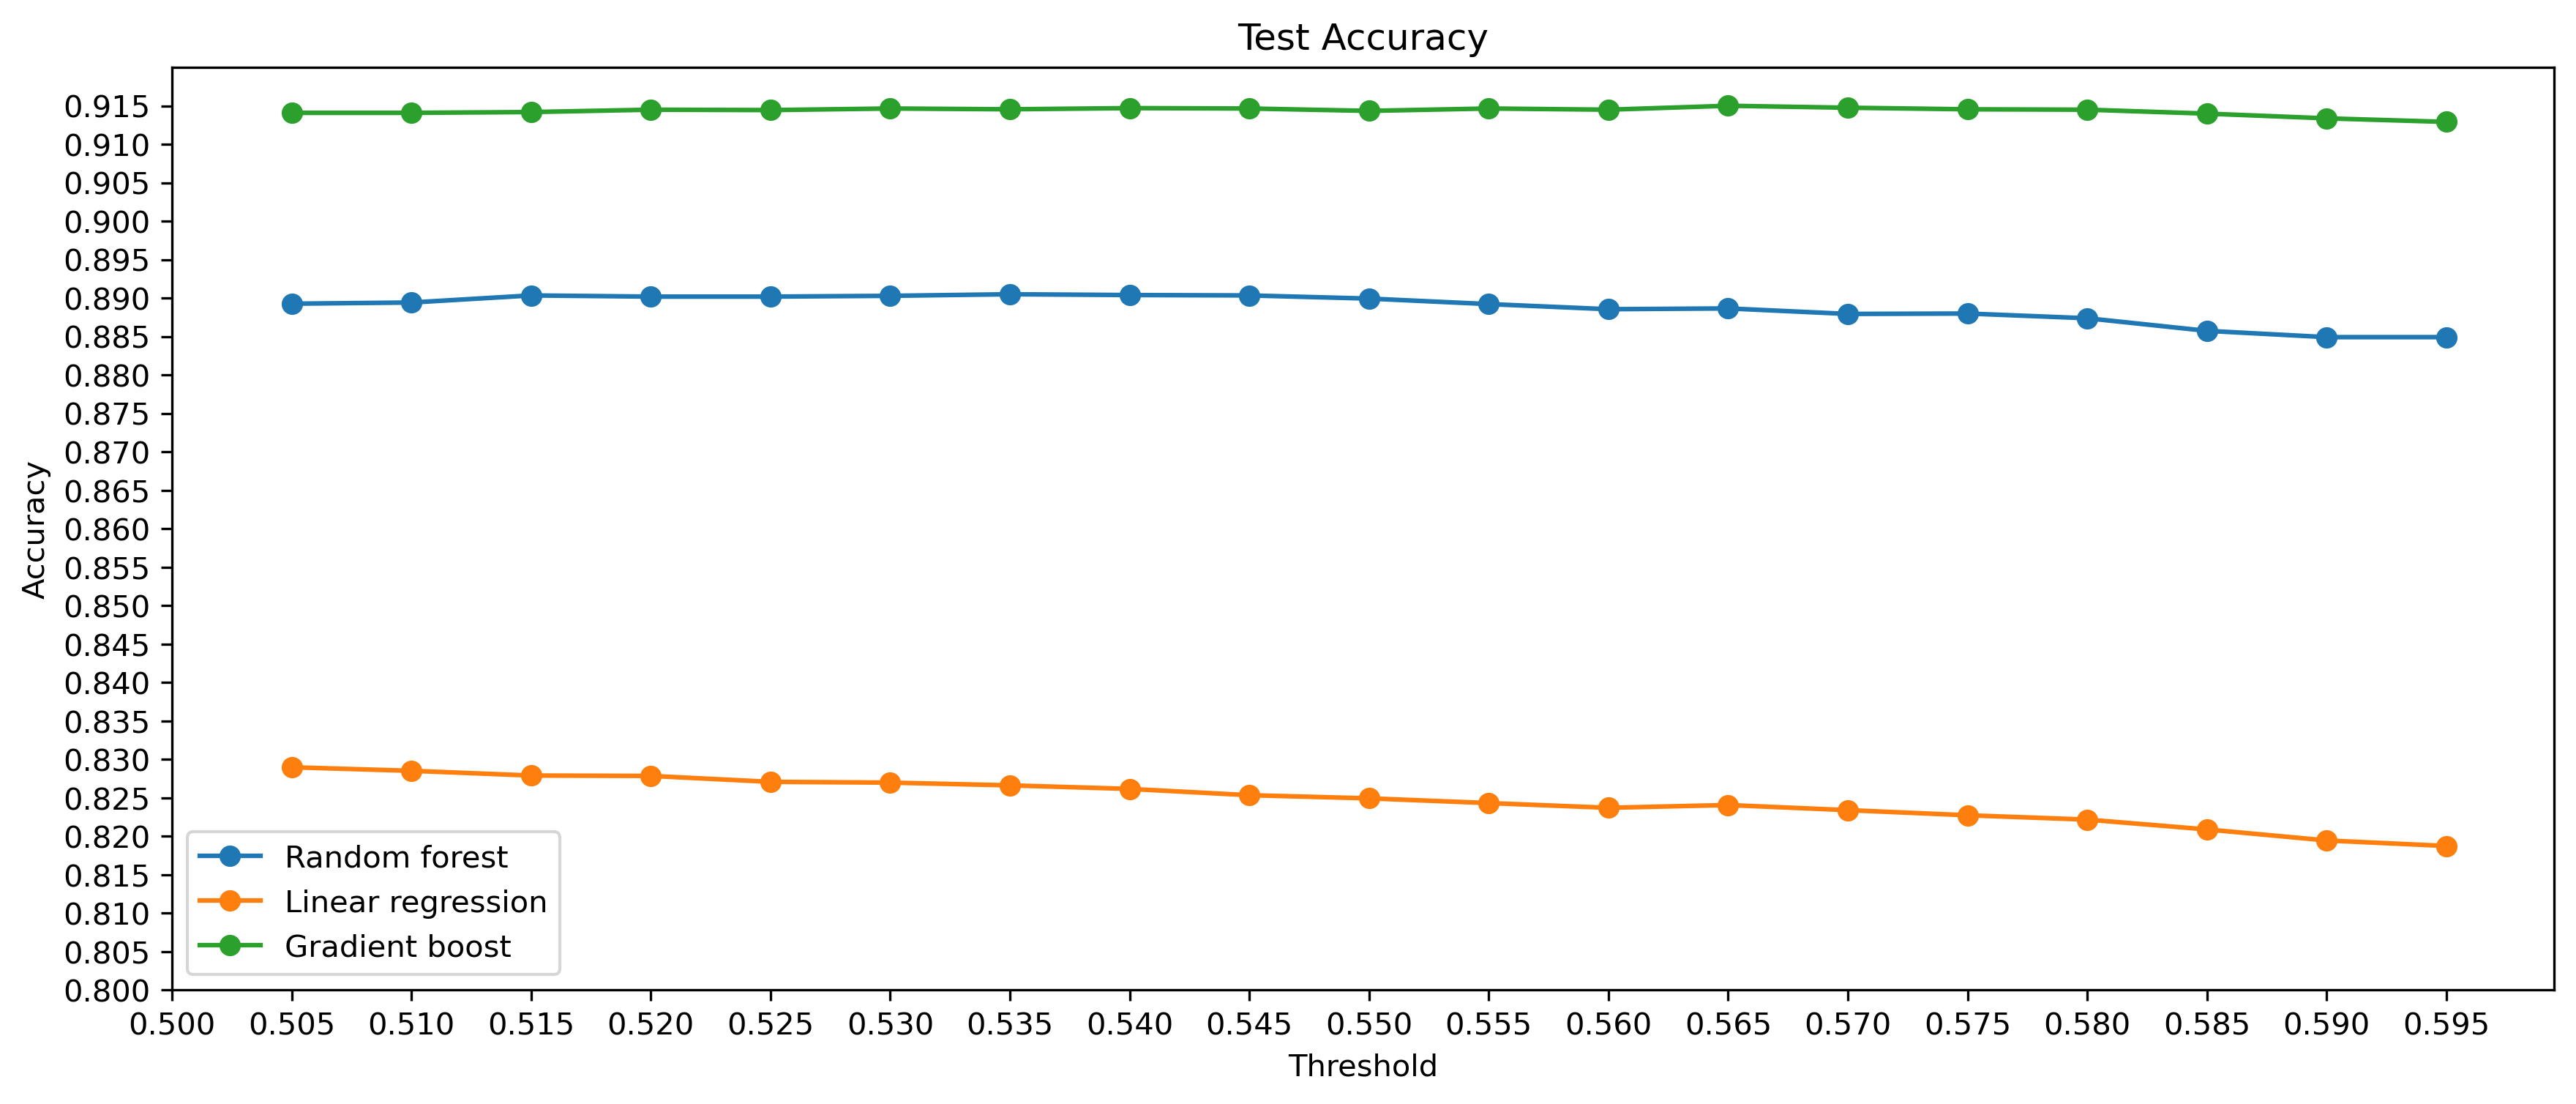

In [52]:
# Skip the first and last entry in each array
thresholds_sliced = thresholds[1:-1]

acc1Test_sliced = acc1Test[1:-1]
acc2Test_sliced = acc2Test[1:-1]
acc3Test_sliced = acc3Test[1:-1]

dpi = 300 
plt.rcParams['figure.dpi'] = dpi
plt.rcParams["figure.figsize"] = (14, 12)

plt.subplot(212)
plt.plot(thresholds_sliced, acc1Test_sliced, '-o', label = "Random forest")
plt.plot(thresholds_sliced, acc2Test_sliced, '-o', label = "Linear regression")
plt.plot(thresholds_sliced, acc3Test_sliced, '-o', label = "Gradient boost")
plt.title("Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Threshold")
plt.xticks(np.arange(0.50, 0.60, 0.005))
plt.ylim(0.80, 0.92)
plt.yticks(np.arange(0.80, 0.92, 0.005))
plt.legend()

plt.show()

